In [1]:
# code aangepast van https://www.philschmid.de/bert-text-classification-in-a-different-language
!ipython kernel install --user --name DataLabDisc
!which jupyter
!pip list

Installed kernelspec DataLabDisc in /data/milenadeswart/.local/share/jupyter/kernels/datalabdisc
/data/anaconda3/bin/jupyter
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Package                            Version
---------------------------------- -----------
absl-py                            2.1.0
accelerate                         0.20.1
aiohttp                            3.8.6
aiosignal                          1.3.1
alabaster                          0.7.12
alembic                            1.3.1
altair                             5.0.1
anaconda-client                    1.7.2
anaconda-navigator                 1.9.7
anaconda-project                   0.8.3
appdirs                            1.4.4
asn1crypto                         1.0.1
ast_decompiler                     0.7.0
astatine                           0.3.3
astor                   

multiprocess                       0.70.14
mypy-extensions                    1.0.0
natsort                            8.4.0
navigator-updater                  0.2.1
nbclient                           0.7.4
nbconvert                          7.6.0
nbformat                           5.8.0
nest-asyncio                       1.6.0
networkx                           2.3
nltk                               3.4.5
nose                               1.3.7
notebook                           6.0.1
numba                              0.45.1
numexpr                            2.7.0
numpy                              1.21.6
numpydoc                           0.9.1
nvidia-cublas-cu11                 11.10.3.66
nvidia-cuda-nvrtc-cu11             11.7.99
nvidia-cuda-runtime-cu11           11.7.99
nvidia-cudnn-cu11                  8.5.0.96
oauthlib                           3.0.1
olefile                            0.46
openpyxl                           3.0.0
opt-einsum                         3.3.0
pac

In [2]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics as metrics
from scipy.special import expit
import seaborn as sns
from datasets.dataset_dict import DatasetDict
from datasets import Dataset
import torch
import pyarrow
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModel, TFAutoModel
from simpletransformers.classification import ClassificationModel
from simpletransformers.classification import ClassificationArgs
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score, accuracy_score
#import warnings
#warnings.filterwarnings('ignore')

seed = 9

/data/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# check device waarop de code runt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cpu


In [4]:
# gebruik pretrained model (cased!): https://huggingface.co/GroNLP/bert-base-dutch-cased
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# inladen & mergen data
def merge_annotated_data(naam_dataset, n_annotators, n_annotations = 3):
    """ functie die de gesplitste data gesplitst door split_annotated_data weer kan samenvoegen.
    De datasets met de naam naam_dataset_n_annotators.csv worden ingeladen. Vervolgens wordt de oorspronkelijke dataset gereconstrueerd
    uit de ingeladen data. De oorspronkelijke zinnen en het overzicht van de labels wordt gereturned.

    Input:
    naam_dataset: str, de naam van de documenen die de annotators hebben ingevuld
    n_annotators: int, het aantal annotators
    n_annotations: int, het aantal annotations per zin. default 3

    Output:
    merged_data: een DataFrame met daarin de oorspronkelijke data en de n_annotations labels die zijn toegekend.
    """
    # inladen path naar data en creëren lege frames
    dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/Datasets_2/"
    merged_data = pd.DataFrame()

    for i in range(n_annotators):
        # inladen annotated documenten en samenvoegen
        annotated_doc = pd.read_excel(dataset_path + naam_dataset + "_" + str(i) + '.xlsx')
        annotated_doc = annotated_doc.dropna(subset=['Label', 'text', 'Column1'])
        print(len(annotated_doc))
        columns = list(annotated_doc.columns)

        #display(annotated_doc)

        # document opstellen
        if i == 0:
            merged_data = annotated_doc
        else:
            merged_data = pd.concat([merged_data, annotated_doc])
    
    extra_zoekwoorden = pd.read_excel(dataset_path + 'te_verwijderen.xlsx')
    merged_data = pd.concat([merged_data, extra_zoekwoorden])
    
    missende_zoekwoorden = pd.read_excel(dataset_path + 'missing_words.xlsx')
    merged_data = pd.concat([merged_data, missende_zoekwoorden])
    
    extra_migratie = pd.read_excel(dataset_path + 'extra_migratie.xlsx')
    merged_data = pd.concat([merged_data, extra_migratie])
    
    herlabelled = pd.read_excel(dataset_path + 'herlabellen.xlsx')
    merged_data = pd.concat([merged_data, herlabelled])
    
    #display(merged_data)

    aggregated_data = merged_data.groupby(['Column1']).agg({'id': 'last', 'titel': 'last', 'text': 'last', 'zin': 'last', 'word': 'last', 'Label': 'last'})
    
    print(len(merged_data), len(aggregated_data)) 
    
    #aggregated_data = aggregated_data.sort_values(by = ['Column1'])

    return pd.DataFrame(merged_data), pd.DataFrame(aggregated_data)

merged, aggregated = merge_annotated_data('te_labellen', n_annotators = 8, n_annotations = 3)

display(merged)

169
451
423
421
604
772
296
545
5121 4679


,Column1,id,pagina,zin,type_document,soort,document_nummer,titel,onderwerp,datum,...,word,categorie,doel,voorkeur,vermijden,toelichting,labeller_1,labeller_2,labeller_3,Column2
3,26136,9a3e78d8-05b3-4a31-b20e-a7a8ecf38006,18,51,Hoofddocument,Memorie van toelichting,2019D07551,Wijziging van de Wet langdurige zorg om toegan...,Memorie van toelichting,2019-02-20,...,stromen,migratie,context/vermijden,NaN,tsunami,NaN,1.0,2.0,3.0,NaN
5,18406,aa7d30cb-5023-4a90-bc82-8a4620a1f197,5,2,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2014D12472,Voorstel van het lid Halsema tot wijziging van...,Nota naar aanleiding van het verslag,2007-01-25,...,macht,algemeen,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
6,9109,f0ab3dbd-32c1-41ab-ad8f-433c42ddaa2a,108,2,Hoofddocument,Memorie van toelichting,2009D43081,Vaststelling van de begrotingsstaten van het M...,Memorie van toelichting,2009-09-15,...,armoede,talen buiten nl,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
7,1887,fe98cf25-0b37-47d3-b866-0c1511139f66,41,13,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2023D07671,Wijziging van het Wetboek van Strafrecht en an...,Nota naar aanleiding van het verslag,2023-03-09,...,seksueel,seksualiteit,context,NaN,NaN,NaN,1.0,2.0,3.0,NaN
9,139,4f54bb19-34ba-4db6-a301-017ba2bdbc42,45,12,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2022D24395,Wijziging van het Wetboek van Burgerlijke Rech...,Nota naar aanleiding van het verslag,2022-06-20,...,stroom,migratie,context/vermijden,NaN,NaN,NaN,1.0,2.0,3.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,33861,fa1e13f1-67d0-4d3d-a2e9-decb637c5820,72,6,Hoofddocument,Rapport,2023D04549,Parlementaire enquête aardgaswinning Groningen,Deelrapport 2 - Feitenreconstructie 1959-2012,2023-02-24,...,kloof,gender,context,NaN,NaN,NaN,70.0,80.0,10.0,421.0
57,4478,d9bc4df6-5031-4ede-bdc6-22e827eb1de2,33,2,Hoofddocument,Nota n.a.v. het (nader/tweede nader/enz.) verslag,2016D45687,Wijziging van de Wet inburgering en enkele and...,Nota naar aanleiding van het verslag,2016-11-29,...,nieuwkomer,migratie,context,NaN,NaN,NaN,70.0,80.0,10.0,520.0
58,17405,497ce633-51c0-416d-a80d-8274f100d835,3,10,Hoofddocument,Memorie van toelichting (initiatiefvoorstel),2016D30337,Voorstel van wet van het lid Van Klaveren betr...,Memorie van toelichting,2016-07-18,...,minderheden,algemeen,context,NaN,NaN,"vermijd othering, rol slachtoffers",70.0,80.0,10.0,523.0
59,10024,0df009bc-3b60-4f2c-952c-49e27c7e4169,13,1,Hoofddocument,Memorie van toelichting,2015D32662,Vaststelling van de begrotingsstaten van het M...,Memorie van toelichting,2015-09-15,...,migranten,migratie,context,NaN,NaN,NaN,70.0,80.0,10.0,527.0


In [6]:
# bekijken dataset
print(merged.columns)

pos = len(aggregated[aggregated.Label == 1.0])
neg = len(aggregated[aggregated.Label==0.0])
unclear = len(aggregated[aggregated.Label==4.0])
useless = len(aggregated[aggregated.Label==7.0])

print(f"The dataset has {pos} biased and {neg} unbiased instances for a total of {pos+neg}. There are {unclear} unclear labels and {useless} useless instances.")

Index(['Column1', 'id', 'pagina', 'zin', 'type_document', 'soort',
       'document_nummer', 'titel', 'onderwerp', 'datum', 'vergaderjaar',
       'kamer', 'volgnummer', 'citeertitel', 'alias', 'datum_registratie',
       'datum_ontvangst', 'aanhangselnummer', 'kenmerk_afzender',
       'organisatie', 'content_type', 'content_length', 'gewijzigd_op',
       'api_gewijzigd_op', 'verwijderd', 'url_document', 'id_hoofddocument',
       'text', 'Label', 'word', 'categorie', 'doel', 'voorkeur', 'vermijden',
       'toelichting', 'labeller_1', 'labeller_2', 'labeller_3', 'Column2'],
      dtype='object')
The dataset has 894 biased and 2738 unbiased instances for a total of 3632. There are 32 unclear labels and 1010 useless instances.


In [7]:
zoekwoorden_set = set(merged['word'])

print(len(zoekwoorden_set))

zoekwoorden = ['meerbloed', 'hij of zij', 'rolstoelgebonden', 'Andere achtergrond', 'westers', 'mbo-leerling', 'slaven', 'berber', 'joods', 'zwarte school', 'grensoverschrijdend gedrag', 'halfbloed', 'gekleurd', 'hij/zij', 'ontwikkelingslanden', 'plusklassen', 'doventolk', 'probleembuurt', 'zittenblijven', 'zwart', 'lager opgeleid', 'minderheden', 'handicap', 'blank', 'kaukasisch', 'juf ', 'begeleider', 'mohammedaan', 'gebarentolk', 'etnisch', 'bruin', 'thuiszitter', 'stroom', 'derde wereld', 'privilege', 'islam ', 'fobie', 'dubbelbloed', 'stromen', 'non-binair', 'inheems', 'ras', 'excellente school', 'speciaal onderwijs', 'gouden eeuw', 'transseksueel', 'man', 'page', 'rolstoeler', 'ontdekken', 'anderstalig', 'opstromen', 'caribisch gebied', 'gehandicapt', 'rolstoelrijder', 'slavernijverleden', 'hoogopgeleid', 'travestiet', 'tussenpositie', 'witte school', 'slaaf', 'mavo', 'racisme', 'hoofddoek', 'jongen', 'achterstandsscore', 'turk', 'ontdekking', 'medicijnman', 'bediende', 'zigeuner', 'nieuwkomer', 'afstromen', 'arabisch', 'macht', 'exotisch', 'islamiet', 'eskimo', 'oostblok', 'laag opgeleid', 'transgender', 'geslacht', 'armoede', 'lagelonenlanden', 'bi-cultureel', 'verliefd', 'probleemkinderen', 'mbo-cursist', 'ouders', 'hermafrodiet', 'probleemwijk', 'achterstandsschool', 'primitief', 'praktisch geschoold', 'christen', 'mbo-deelnemer', 'dames en heren', 'kloof', 'vluchtelingencrisis', 'achterstandsleerling', 'nieuwe nederlander', 'indiaan', 'queer', 'autochtoon', 'theoretisch geschoold', 'donker', 'meisje', 'allochtoon', 'bicultureel', 'hetero', 'west', 'homo', 'laagopgeleid', 'vrouw', 'seksueel', 'traditie', 'passend onderwijs', 'migranten', 'dwerg', 'achterstandsscholen']
zoekwoorden = set(zoekwoorden)

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))

print(afwezig)

53
71
{'grensoverschrijdend gedrag', 'gebarentolk', 'mohammedaan', 'dwerg', 'bruin', 'travestiet', 'derde wereld', 'exotisch', 'passend onderwijs', 'primitief', 'autochtoon', 'medicijnman', 'theoretisch geschoold', 'queer', 'handicap', 'islam ', 'rolstoeler', 'juf ', 'hij of zij', 'achterstandsschool', 'gouden eeuw', 'excellente school', 'allochtoon', 'speciaal onderwijs', 'non-binair', 'kaukasisch', 'nieuwe nederlander', 'rolstoelrijder', 'turk', 'doventolk', 'praktisch geschoold', 'laag opgeleid', 'eskimo', 'plusklassen', 'rolstoelgebonden', 'caribisch gebied', 'halfbloed', 'donker', 'bediende', 'probleemkinderen', 'zigeuner', 'mavo', 'zwarte school', 'transseksueel', 'ontdekken', 'westers', 'mbo-deelnemer', 'hermafrodiet', 'achterstandsscore', 'meerbloed', 'mbo-leerling', 'gekleurd', 'berber', 'dubbelbloed', 'achterstandsscholen', 'dames en heren', 'indiaan', 'bicultureel', 'lager opgeleid', 'zwart', 'bi-cultureel', 'witte school', 'ontdekking', 'probleemwijk', 'lagelonenlanden', 'p

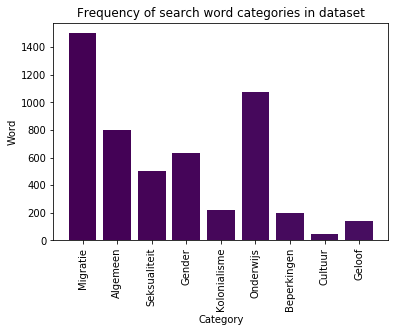

{'Migratie': 1501, 'Algemeen': 803, 'Seksualiteit': 499, 'Gender': 630, 'Kolonialisme': 220, 'Onderwijs': 1078, 'Beperkingen': 200, 'Cultuur': 43, 'Geloof': 140}


In [8]:
dataset_path = "~/share/Milena/programma-discriminatie-en-racisme/datasets/"
zoekwoorden = pd.read_excel(dataset_path + "Zoekwoorden15.03.24.xlsx", names = ['Categorie', 'Zoekwoord', 'Doel', 'Voorkeur', 'Vermijden', 'Toelichting'])

search_dict = dict(zip(zoekwoorden['Zoekwoord'], zoekwoorden['Categorie']))
#print(search_dict)

# leuk grafiekje van hoe vaak woorden voorkomen
word_freq = {}
i = 0

for woord in merged['word']:
    category = search_dict[woord]
    
    if category in word_freq:
        word_freq[category] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[category] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Word')
plt.title('Frequency of search word categories in dataset')
plt.show()

print(word_freq)

In [9]:
print(len(aggregated))

# prepareer dataset voor inladen in model
model_data = aggregated[aggregated.Label < 2.0]

model_data = model_data.drop(columns = ['id', 'titel', 'zin'])
model_data = model_data.rename(columns={"Label": "label", 'text': 'text'}) # totaalscore/label = doel, text = ingelezen tekst

display(model_data)

4679


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9874,een functiestoornis is een langdurige of blijv...,fobie,1.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [10]:
word_freq_dict = {}

for woord in model_data['word']:
    if woord in word_freq_dict:
        word_freq_dict[woord] += 1
    else:
        word_freq_dict[woord] = 1
        
print(word_freq_dict)

new_words_list = []

for key in word_freq_dict:
    value = word_freq_dict[key]
    if value < 10:
        new_words_list.append(key)
        
print(new_words_list)

# then, remove instances with key words from this unseen words list
new_words_data = pd.DataFrame()

for new_word in new_words_list:
    new_word_data = model_data[model_data['word'] == new_word]
    new_words_data = pd.concat([new_words_data, new_word_data])

display(new_words_data)

model_data = model_data[~model_data['word'].isin(new_words_data['word'])]
display(model_data)

{'stromen': 521, 'traditie': 38, 'hetero': 53, 'stroom': 473, 'macht': 365, 'geslacht': 255, 'armoede': 214, 'seksueel': 376, 'migranten': 161, 'ouders': 205, 'christen': 38, 'gehandicapt': 146, 'racisme': 31, 'minderheden': 63, 'mankracht': 90, 'meisje': 77, 'afstromen': 19, 'islam': 48, 'zittenblijven': 20, 'homo': 15, 'joods': 16, 'privilege': 20, 'blank': 9, 'hoogopgeleid': 40, 'nieuwkomer': 13, 'opstromen': 9, 'anderstalig': 51, 'slaaf': 12, 'slavernijverleden': 26, 'laagopgeleid': 26, 'kloof': 23, 'slaven': 9, 'transgender': 65, 'jongen': 15, 'arabisch': 31, 'vluchtelingencrisis': 8, 'fobie': 5, 'hoofddoek': 17, 'thuiszitter': 4, 'achterstandsleerling': 2, 'juf': 9, 'verliefd': 4, 'inheems': 6, 'tussenpositie': 3, 'oostblok': 1}
['blank', 'opstromen', 'slaven', 'vluchtelingencrisis', 'fobie', 'thuiszitter', 'achterstandsleerling', 'juf', 'verliefd', 'inheems', 'tussenpositie', 'oostblok']


,text,word,label
Column1,,,
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
36171,met recht kunnen we spreken over illusies van ...,blank,0.0
3677,niet-dossierstuk over de afgelopen twintig jaa...,blank,0.0
3678,"blank en haelermans, die in het antwoord op vr...",blank,0.0
...,...,...,...
25098,"de wet verbiedt het doden, het vangen en het v...",inheems,0.0
15972,in de structuur van het huidige en het nieuwe ...,tussenpositie,0.0
5006,de nla verzoekt te bezien of het mogelijk is o...,tussenpositie,0.0


,text,word,label
Column1,,,
38,door tegelijkertijd voor werkgevers de verschi...,stromen,0.0
50,de regering is zich zeer bewust van de nederla...,traditie,0.0
53,dienovereenkomstig streeft elke partij ernaar ...,stromen,0.0
110,tweede kamer der staten-generaal 2 vergaderjaa...,hetero,0.0
112,b in de beweegreden wordt «hetero- of homoseks...,hetero,0.0
...,...,...,...
9869,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9870,ten aanzien van studenten die tijdelijk een an...,stromen,0.0
9910,een prejudiciële procedure is daarmee niet all...,macht,0.0


In [11]:
# implementeer undersampling, oversampling, normaal sampling
def sampling_strategy(input_frame, strategy = 'normal', max = 0.7, balance = 0.5):
    if strategy == 'oversampling': # F1 = 0.78
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        output_frame = pd.concat([pos, pos, neg]) # double the sample of positive instances
        
    elif strategy == 'undersampling': # F1 = 0.80
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        max_len = int(max*len(neg))
        output_frame = pd.concat([pos, neg[0:max_len]])
        
    elif strategy == 'balanced': # F1 =
        # len(input_frame) = len(output_frame)
        pos = input_frame[input_frame.label == 1.0]
        neg = input_frame[input_frame.label==0.0]
        neg_len = int(len(input_frame) * balance)
        pos_extra_len = len(input_frame) - neg_len - len(pos)
        output_frame = pd.concat([pos, neg[0:neg_len]])
        
        while pos_extra_len/len(pos) > 1:
            output_frame = pd.concat([output_frame, pos]) # heel extra frame toevoegen
            pos_extra_len -= len(pos)
            
        # anders: overig toevoegen
        output_frame = pd.concat([output_frame, pos[0:pos_extra_len]])
    
    else: #strategy = 'normal' # F1 = 0.78
        output_frame = input_frame[input_frame.label < 2.0] # behoudt alleen labels 0 en 1
    return output_frame

In [12]:
# split dataset: 60% train, 20% val, 20% test
train_val_df, test_df_words = train_test_split(model_data, test_size=0.20, stratify = model_data['label'], random_state=seed)
train_df_words, val_df_words = train_test_split(train_val_df, test_size=0.25, stratify = train_val_df['label'], random_state=seed)

train_df_words = sampling_strategy(train_df_words, strategy = 'undersampling')

train_df = train_df_words.drop(columns = ['word'])
val_df = val_df_words.drop(columns = ['word'])
test_df = test_df_words.drop(columns = ['word'])
new_test_df = new_words_data.drop(columns = ['word'])

print(len(train_df), len(val_df), len(test_df))
print(len(train_df[train_df['label']==1.0]))

1649 713 713
511


/data/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/data/anaconda3/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

In [13]:
zoekwoorden_set = set(test_df_words['word'])

print(len(zoekwoorden_set))

zoekwoorden = set(merged['word'])

afwezig = zoekwoorden - zoekwoorden_set
print(len(afwezig))
print(afwezig)

33
20
{nan, 'man', 'oostblok', 'inheems', 'west', 'etnisch', 'blank', 'achterstandsleerling', 'thuiszitter', 'ras', 'opstromen', 'vluchtelingencrisis', 'juf', 'ontwikkelingslanden', 'tussenpositie', 'vrouw', 'fobie', 'slaven', 'verliefd', 'begeleider'}


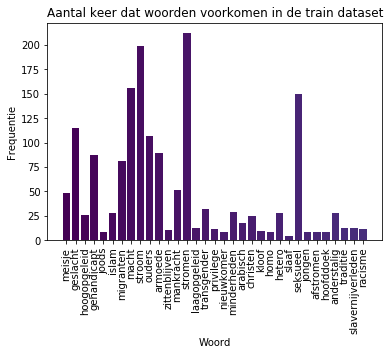

{'meisje': 48, 'geslacht': 115, 'hoogopgeleid': 26, 'gehandicapt': 87, 'joods': 9, 'islam': 28, 'migranten': 81, 'macht': 156, 'stroom': 199, 'ouders': 107, 'armoede': 89, 'zittenblijven': 11, 'mankracht': 52, 'stromen': 212, 'laagopgeleid': 13, 'transgender': 32, 'privilege': 12, 'nieuwkomer': 8, 'minderheden': 29, 'arabisch': 18, 'christen': 25, 'kloof': 10, 'homo': 9, 'hetero': 28, 'slaaf': 4, 'seksueel': 150, 'jongen': 8, 'afstromen': 8, 'hoofddoek': 9, 'anderstalig': 28, 'traditie': 13, 'slavernijverleden': 13, 'racisme': 12}


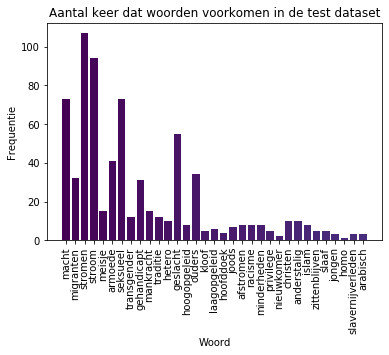

{'macht': 73, 'migranten': 32, 'stromen': 107, 'stroom': 94, 'meisje': 15, 'armoede': 41, 'seksueel': 73, 'transgender': 12, 'gehandicapt': 31, 'mankracht': 15, 'traditie': 12, 'hetero': 10, 'geslacht': 55, 'hoogopgeleid': 8, 'ouders': 34, 'kloof': 5, 'laagopgeleid': 6, 'hoofddoek': 4, 'joods': 7, 'afstromen': 8, 'racisme': 8, 'minderheden': 8, 'privilege': 5, 'nieuwkomer': 2, 'christen': 10, 'anderstalig': 10, 'islam': 8, 'zittenblijven': 5, 'slaaf': 5, 'jongen': 3, 'homo': 1, 'slavernijverleden': 3, 'arabisch': 3}


In [14]:
# hoe vaak zitten woorden in de train set?
word_freq = {}

for woord in train_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de train dataset')
plt.show()

print(word_freq)

# en in de test set?
word_freq = {}

for woord in test_df_words['word']:
    if woord in word_freq:
        word_freq[woord] += 1
    elif pd.isna(woord) == True:
        pass
    else:
        word_freq[woord] = 1
        
mycmap = plt.get_cmap("viridis").colors
        
plt.bar(word_freq.keys(), word_freq.values(), color = mycmap)
plt.xticks(rotation=90)
plt.xlabel('Woord')
plt.ylabel('Frequentie')
plt.title('Aantal keer dat woorden voorkomen in de test dataset')
plt.show()

print(word_freq)

In [15]:
# define hyperparameters
# to change parameters: zie https://simpletransformers.ai/docs/usage/#configuring-a-simple-transformers-model
train_args ={"reprocess_input_data": True, # tokenization gebeurt binnen model
             "fp16":False, # vorm van de input van de data
             "silent": False, # zeker weten dat progress bars worden geprint
             "use_multiprocessing": False, # versnelt training
             "use_multiprocessing_for_evaluation": False, # versnelt training
             "overwrite_output_dir": True, # niet ieder model opslaan
             "save_total_limit": 2, # slaat meest recente en beste epoch op
             "save_strategy": 'no', # niet tussentijds opslaan
             "load_best_model_at_end": True, # het beste model inladen
             "num_train_epochs": 4, # hoeveel epochs
             "learning_rate": 0.00002, # learning rate
             "weight_decay": 0.1,
             "optimizer": 'AdamW',
             #"loss_type": "custom",
             #"hidden_dropout_prob": 0.5,
             "evaluate_during_training": True, # om validation data in te laten
            "evaluation_strategy":"epoch", # slaat een tussentijds model op om te evalueren
            #"eval_steps": 2000, # hoe vaak het model wordt opgeslagen
            "train_batch_size": 8, # batch size trainingsdata
            "eval_batch_size": 8} # batch size validation data

model_args = ClassificationArgs()
model_args.reprocess_input_data = True
model_args.fp16 = False
model_args.silent = False
model_args.use_multiprocessing = False
model_args.use_multiprocessing_for_evaluation = False
model_args.overwrite_output_dir = True
model_args.save_total_limit = 2
model_args.save_strategy = "no"
model_args.load_best_model_at_end = True
model_args.num_train_epochs = 4
model_args.learning_rate = 0.00002
model_args.optimizer = "AdamW"
model_args.relative_step = True
model_args.warmup_init = True
model_args.evaluation_during_training = True
model_args.evaluation_strategy = "epoch"
model_args.hidden_dropout_prob = 0.3
model_args.train_batch_size = 8
model_args.eval_batch_size = 8
model_args.no_cache = False

# Create a ClassificationModel (code uit bron; zie bovenaan notebook)
model = ClassificationModel(
    "bert", "GroNLP/bert-base-dutch-cased", # Nederlands!!
    #"bert", "bert-base-uncased", # English!!
    num_labels=2, # hoeveel mogelijke targets er zijn
    args=train_args,
    use_cuda=False # omdat dit op de cpu draait
)

Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.weight', 'ber

In [ ]:
# trainen!
train_results = model.train_model(train_df = train_df, eval_df = val_df)

/data/milenadeswart/.local/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:613: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/207 [00:00<?, ?it/s]

/data/milenadeswart/.local/lib/python3.7/site-packages/simpletransformers/classification/classification_model.py:1455: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 4:   0%|          | 0/207 [00:00<?, ?it/s]

In [ ]:
# testen
# om f1 te kunnen genereren
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')

result, model_outputs, wrong_predictions = model.eval_model(test_df, f1=f1_multiclass, acc=accuracy_score)


In [ ]:
# resultaten: mcc = , tp = true positives, tn = true negatives, fp = false negatives, fn = false negatives
print(result)

# 0.7806059741456883, lr = 0.00002, batch = 8, oversampling
# 0.7618282264590501, lr = 0.002, batch = 8, oversampling
# 0.80, lr = default, batch = 8, undersampling
# 0.7892210553443721, lr = 0.00002, batch = 24, oversampling
# 0.7727849196570864, lr = 0.00002, batch = 24, balanced sampling
# 0.7643486483807626, lr = 0.00002, batch = 24, undersampling
# 0.7721387757070184, lr = 0.0002, batch = 24, undersampling
# 0.7656888451873702, lr = default, batch = 8, undersampling
# 0.7819736575481258, batch = 24, epochs = 8, oversampling (doubled)
# 0.7618978588149389, hidden dropout of 0.5, balanced sampling
# 0.7750330201139665, dropout 0.8, balanced sampling
# 0.7470579808026853, category = oversampling
# 0.7551529031388926, dropout 0.5, batch size = 4
# 0.7599348682562457, weight decay = 0.01
# 0.68260712156061, lr = 0.000002, weight decay = 0.1, batch = 8
# 0.6687961596234598, lr = 0.000002, weight decay = 0
# 0.7672738336177362, lr = 0.00002, weight decay = 0.1, batch = 24
# 0.7565585210545067, epochs = 8, weight decay = 0.2
# 0.7620034919249236, epochs = 8, batch = 8, weight decay = 0.2
# 0.758152920054916, epochs = 16
# 0.7524879530693485, epochs = 7, weight decay = 0.15
# 0.7834716024780142, batch size = 4. weight decay = 0.1
# 0.7808517733050566, weight decay = 0.15
# 0.7731042768563656, weight decay = 0.0, lr = 0.00005
# 0.7701744552093489, lr = 0.00002
# 0.7785754688247835, weight decay = 0.1, lr = 0.00005
# 0.7741168524147247, lr = 0.00001
# 0.7760263421941465, lr = 0.00004, batch = 8
# 0.7696694476713486, dropout = 0.3

# REMOVAL OF UNSEEN WORDS
# 0.7804854943753701

In [ ]:
# test on unseen words
new_test_df = new_words_data.drop(columns = ['word'])

new_result, new_model_outputs, new_wrong_predictions = model.eval_model(new_test_df, f1=f1_multiclass, acc=accuracy_score)

print(new_result)

In [ ]:
# maak een plotje van de loss
print(train_results)

train_losses = train_results[1]['train_loss']
eval_losses = train_results[1]['eval_loss']

plt.plot(train_losses, c = 'teal', label = 'train loss')
plt.plot(eval_losses, c = 'deeppink', label = 'val loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and evaluation loss over time')
plt.show()

In [ ]:
print(model_outputs)

probabilities = expit(model_outputs) # dit is de sigmoid van de voorspelling
print(probabilities)

In [ ]:
#print(list(test_df['text']))

predictions, raw_outputs = model.predict(list(test_df['text']))

new_predictions, new_raw_outputs = model.predict(list(new_test_df['text']))


In [ ]:
print(predictions)
print(list(test_df['label']))

# get correctness of predictions
correct = []

for i in range(len(predictions)):
    if predictions[i] == list(test_df['label'])[i]:
        correct.append(1)
    else:
        correct.append(0)

print(new_predictions)
print(list(new_test_df['label']))

In [ ]:
# confusion matrix
tp = result['tp']
tn = result['tn']
fp = result['fp']
fn = result['fn']
total = tp+tn+fp+fn

tp_rel = tp/(tp+fn)
tn_rel = tn/(tn+fp)
fp_rel = fp/(tn+fp)
fn_rel = fn/(tp+fn)

print(tp_rel, tn_rel, fp_rel, fn_rel)
print(tp, tn, fp, fn)

cm = np.array([[tn_rel, fp_rel], [fn_rel, tp_rel]])
ax = sns.heatmap(cm, annot = True, cmap = "viridis")
ax.set_ylim([0,2])
plt.title("Relative confusion matrix for model test performance (%)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [ ]:
# TO DO: FINISH THIS
# uncertainty of model (violinplot)
print(pd.DataFrame(probabilities).describe())

prob_df = pd.DataFrame(probabilities, columns = ['guess 0', 'guess 1'])
prob_df['correct'] = correct

plt.plot(prob_df['guess 0'][prob_df['correct'] == 1], 'ro', label = 'correct')
plt.plot(prob_df['guess 0'][prob_df['correct'] == 0], 'bx', label = 'incorrect')
plt.ylabel("Certainty of answer being 0")
plt.xlabel("Output number")
plt.legend()
plt.show()

In [ ]:
# kijken naar betrouwbaarheid per zoekwoord
test_df_words['predicted'] = predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(test_df_words)):
    woord = test_df_words['word'].iloc[i]
    label = test_df_words['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if test_df_words['predicted'].iloc[i] == test_df_words['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(dict_label_relative.keys(), dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per word (%)')
plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

In [ ]:
# kijken naar betrouwbaarheid per categorie
new_test_df['predicted'] = new_predictions

dict_word_totals = {}
dict_word_correct = {}
dict_word_relative = {}

dict_label_totals = {}
dict_label_pos = {}
dict_label_relative = {}

for i in range(len(new_words_data)):
    woord = new_words_data['word'].iloc[i]
    label = new_words_data['label'].iloc[i]
    if woord not in dict_word_totals:
        dict_word_totals[woord] = 1
        dict_word_relative[woord] = 0
        dict_label_totals[woord] = 1
        dict_label_relative[woord] = 0
        
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] = 1
        else:
            dict_word_correct[woord] = 0
        
        if label == 1:
            dict_label_pos[woord] = 1
        else:
            dict_label_pos[woord] = 0
            
    else:
        dict_word_totals[woord] += 1
        dict_label_totals[woord] +=1
        if new_test_df['predicted'].iloc[i] == new_test_df['label'].iloc[i]:
            dict_word_correct[woord] += 1
        if label == 1:
            dict_label_pos[woord] += 1
        
    dict_word_relative[woord] = dict_word_correct[woord]/dict_word_totals[woord]
    dict_label_relative[woord] = dict_label_pos[woord]/dict_label_totals[woord]
            
print(dict_word_relative)
print(dict_label_relative)

n=len(dict_word_relative)
r = np.arange(n) 
width = 0.25

plt.bar(dict_word_relative.keys(), dict_word_relative.values(), color = mycmap)
#plt.bar(r+width, dict_label_relative.values(), color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Frequency of correct predictions')
plt.title('Correct predictions by model per unseen word (%)')

plt.show()

# TODO: TOEVOEGEN HOE VEEL VAN DE WOORDEN EEN 1 ZIJN

In [ ]:
# laden beste model en testen van individuele zinnen
# load best model

# input a text to test model on
zin = 'Het zijn ook altijd de mannen die hun zaken niet op orde hebben.'

In [ ]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

class_names = ['positive','negative']

def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    tensor_logits = outputs[0]
    probas = F.softmax(tensor_logits).detach().numpy()
    return probas

text = 'Building more bypasses will help the environment by reducing pollution and traffic jams in towns and cities.'
print(tokenizer(text, return_tensors='pt', padding=True))

explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(text, predictor, num_features=20, num_samples=2000)
exp.show_in_notebook(text=text)

In [ ]:
# OUDE/ANDERE CODE

In [ ]:
#dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
#dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})
print(dataset.columns)


X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

In [ ]:
#tokenized_train = tokenizer(dataset['train']["text"], return_tensors="np", padding=True)
# Tokenizer returns a BatchEncoding, but we convert that to a dict for Keras
#tokenized_data = dict(tokenized_train)
                     
#labels_train = np.array(dataset['train']["label"])  # Label is already an array of 0 and 1)

In [ ]:
# trainen
# sla training_arguments op
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    reprocess_input_data= True,
    fp16=False,
    overwrite_output_dir = True
)

metric = evaluate.load("accuracy")

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
# train model!
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
# maak dataset correcte format: [{'label': value, 'text': text}, {'label': value, 'text': text}]
data = []

for i in range(len(dataset_zoek)):
    label = dataset_zoek['totaalscore'].iloc[i]
    text = dataset_zoek['zin'].iloc[i]
    tokenized_text = tokenizer(str(text), return_tensors="np", padding=True)
    duo = {'label': label, 'text': tokenized_text}
    data.append(duo)
    
print(len(data))

In [ ]:
# split dataset: 60% train, 20% val, 20% test
trainval, test = train_test_split(data, train_size = 0.8)
train, val = train_test_split(trainval, train_size = 0.75)

print(len(train), len(val), len(test))

In [ ]:
train_labels = []

for item in train:
    train_labels.append(item['label'])

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

# Read data
dataset_zoek = pd.read_csv(dataset_path + 'dataset_dummy.csv', sep = ',') # model is te groot om te trainen met volledige dataset zonder GPU
dataset = dataset_zoek.drop(columns = ['Unnamed: 0', 'document', 'zin', 'label', 'score_annotator'])
dataset = dataset.rename(columns={"totaalscore": "label", 'text': 'text'})

# Define pretrained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")
model = AutoModel.from_pretrained("GroNLP/bert-base-dutch-cased")  # PyTorch

# ----- 1. Preprocess data -----#
# Preprocess data
X = list(dataset_zoek["text"])
y = list(dataset_zoek["totaalscore"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)



In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [ ]:
# ----- 3. Predict -----#
# Load test data
test_data = pd.read_csv("test.csv")
X_test = list(test_data["review"])
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
model_path = "output/checkpoint-50000"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [ ]:
ds = Dataset.from_pandas(dataset)

print(ds)

# split dataset: 60% train, 20% val, 20% test
train_testvalid = ds.train_test_split(test_size=0.4)
# Split the 40% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

print(ds['train']['text'][100])

In [ ]:
def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=True,
        tokenizer=None, 
        topic=None, 
        freeze_bert = None, 
        num_feats=None, 
        keep_stopwords = None,
        combined_feats = None, 
        sum_layers = None
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

       
        combined_feats=aggregate_features(outputs, tokenizer, input_ids, topic, 
                                     num_feats, keep_stopwords, sum_layers).to(device)
        combined_feats = self.dropout(combined_feats)
        logits = self.classifier(combined_feats)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )